In [1]:
import torch
import torchvision

from model import ViT

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
img_size = 56

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./images/train', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize((img_size, img_size)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./images/test', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize((img_size, img_size)),
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


100%|██████████| 26421880/26421880 [00:05<00:00, 4522697.09it/s]


Extracting ./images/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./images/train/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 898066.56it/s]

Extracting ./images/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./images/train/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3185905.91it/s]


Extracting ./images/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./images/train/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2089238.22it/s]


Extracting ./images/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./images/train/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:04<00:00, 5657969.73it/s]


Extracting ./images/test/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./images/test/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 887864.04it/s]

Extracting ./images/test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./images/test/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4348053.61it/s]


Extracting ./images/test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./images/test/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8408207.55it/s]

Extracting ./images/test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./images/test/FashionMNIST/raw



In [4]:
model = ViT(in_channels=1, n_classes=10, img_size=img_size,
            depth=3, emb_size=192)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=momentum)

In [5]:
# training loop

losses = []
accuracies = []

for epoch in range(n_epochs):
    # train
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        output = model(data)
        
        loss_val = loss(output, target)
        loss_val.backward()
        optimizer.step()
        
        losses.append(loss_val.item())
        accuracies.append((output.argmax(dim=1) == target).float().mean().item())
            
    # test
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))

  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 7533/10000 (75%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 8057/10000 (81%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 8031/10000 (80%)



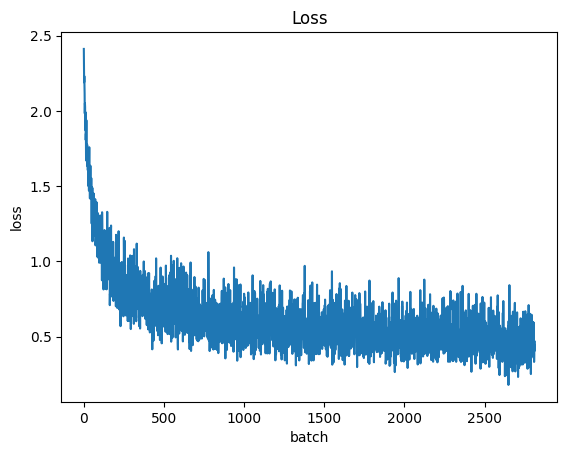

In [6]:
 #plot losses

plt.plot(losses)
plt.title('Loss')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()




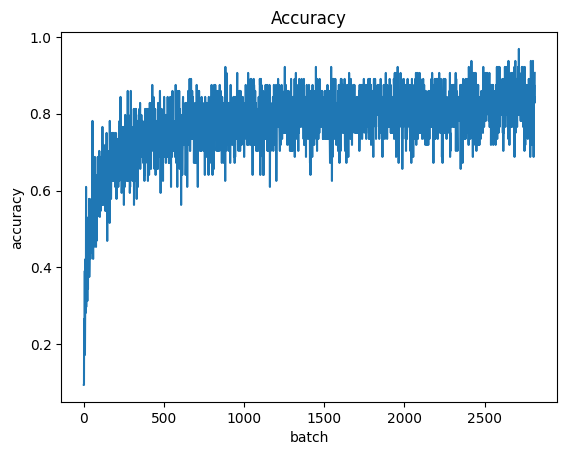

In [7]:
# plot accuracies

plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()
